# Double Classification : Especes et Detection Maladie
## Baseline: 2 Modeles / 2 Outputs

### Importer les librairies et connection au Drive

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
import tensorflow as tf
import os
import pathlib
from PIL import Image 
from sklearn.model_selection import train_test_split
%matplotlib inline

from matplotlib import cm

from imblearn.under_sampling import RandomUnderSampler

from tensorflow.keras.layers import Input, Dense 
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dropout 
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D 
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator


from tensorflow.keras import Sequential
from tensorflow.keras import callbacks

from tensorflow.keras.applications.vgg16 import VGG16


from sklearn import metrics # Pour évaluer les modèles

import itertools # Pour créer des iterateurs

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Recuperation de l'echantillon de validation

#### Valid Dataset

In [ ]:
# folder_path = "/content/drive/MyDrive/Kaggle/new-plant-diseases-dataset/valid/"
folder_path = "/content/drive/MyDrive/NewPlantDiseasesDataset/valid/"

X_valid0=[]
y1_valid0=[] # La categorie
y2_valid0=[] # Le statut is Healthy ou pas
y3_valid0=[] # Le type de maladie ou Healthy
y4_valid0=[] # un eliste de vecteur (Category,Healthy)

width = 100
height = 100 # resize to 100x100 to solve the RAM issue in Kaggle notebooks

for path, dirs, files in os.walk(folder_path):
    for repertoire in dirs:
      chemin=folder_path+repertoire
      for images in os.listdir(chemin):
        img=cv2.imread(chemin+'/'+images,cv2.IMREAD_COLOR )
        img_resized = cv2.resize(img, (width,height)) 
        X_valid0.append(np.array(img_resized))
        categorie=repertoire.split('___')[0]
        y1_valid0.append(categorie)   # On recupere la categorie seulement 
        healthy=("healthy" in repertoire)*1 
        y2_valid0.append(healthy) # On recupere le status Healthy
        y3_valid0.append(repertoire.split('___')[1]) # On recupere la maladie (y compris Healthy)
        y4_valid0.append((categorie,healthy))



In [ ]:
X_valid= np.array(X_valid0)/255
X_valid = X_valid.astype('float32')
y1_valid0= np.array(y1_valid0)
y2_valid0= np.array(y2_valid0)
y3_valid0= np.array(y3_valid0)


In [ ]:
X_valid.shape

(17572, 100, 100, 3)

In [ ]:
pd.DataFrame(y1_valid0).value_counts()

Tomato                     4585
Apple                      1943
Corn_(maize)               1829
Grape                      1805
Potato                     1426
Pepper,_bell                975
Strawberry                  900
Peach                       891
Cherry_(including_sour)     877
Soybean                     505
Orange                      503
Blueberry                   454
Raspberry                   445
Squash                      434
dtype: int64

In [ ]:
pd.DataFrame(y2_valid0).value_counts()

0    12000
1     5572
dtype: int64

### 1- Recuperation du modele Classification par espece

In [ ]:
reconstructed_model_categorie = load_model("/content/drive/MyDrive/model_LeNet1_Categorie_AllData_Softmax") # sans undersampling



In [ ]:
# Nouvelles predictions du modele
pred_categorie=reconstructed_model_categorie.predict(X_valid)

pred_categorie_class = pred_categorie.argmax(axis = 1)
pred_categorie_confiance=pd.DataFrame(pred_categorie.max(axis=1), columns=['confiance'])

# Pour retrouver facilement les noms des labels
dict_categorie = {0 : 'Apple', 1 : 'Blueberry', 2: 'Cherry', 3: 'Corn', 4: 'Grape', 5:'Orange', 6: 'Peach',
        7: 'Pepper', 8: 'Potato', 9: 'Raspberry', 10: 'Soybean', 11:'Squash', 12:'Strawberry', 13:'Tomato'}

# on met les labels pour que ce soit plus facile a lire
pred_categorie_label = (pd.DataFrame(pred_categorie_class, columns=['categorie'])).replace({"categorie": dict_categorie})
y1_valid =  (pd.DataFrame((y1_valid0), columns=['categorie_reelle'])).replace(to_replace= ['Corn_(maize)','Pepper,_bell','Cherry_(including_sour)'],
                                                                             value= ['Corn', 'Pepper','Cherry'] )





In [ ]:
print(metrics.classification_report(y1_valid, pred_categorie_label))

              precision    recall  f1-score   support

       Apple       0.94      0.96      0.95      1943
   Blueberry       0.96      0.96      0.96       454
      Cherry       0.98      0.95      0.96       877
        Corn       0.99      0.98      0.98      1829
       Grape       1.00      0.98      0.99      1805
      Orange       0.99      0.96      0.98       503
       Peach       0.98      0.89      0.93       891
      Pepper       0.97      0.86      0.92       975
      Potato       0.89      0.99      0.93      1426
   Raspberry       0.98      0.96      0.97       445
     Soybean       0.94      0.94      0.94       505
      Squash       0.96      0.99      0.98       434
  Strawberry       0.97      0.98      0.98       900
      Tomato       0.96      0.98      0.97      4585

    accuracy                           0.96     17572
   macro avg       0.96      0.96      0.96     17572
weighted avg       0.96      0.96      0.96     17572



In [ ]:
# On retrouve bien les performance!

### 2 - Recuperation du modele healthy/UnHealthy

In [ ]:
reconstructed_model_healthy = load_model("/content/drive/MyDrive/model_isHealthy_18K")

In [ ]:
# Nouvelles predictions du modele
pred_healthy=reconstructed_model_healthy.predict(X_valid)
pred_healthy_class= pd.DataFrame(pred_healthy.round(), columns=['healthy'])
y2_valid =  (pd.DataFrame((y2_valid0), columns=['healthy_reelle']))

In [ ]:
y2_valid.value_counts()

healthy_reelle
0                 12000
1                  5572
dtype: int64

In [ ]:
pred_healthy_class.value_counts()

healthy
0.0        10644
1.0         6928
dtype: int64

In [ ]:
print(metrics.classification_report(y2_valid, pred_healthy_class))

              precision    recall  f1-score   support

           0       1.00      0.88      0.94     12000
           1       0.80      0.99      0.88      5572

    accuracy                           0.92     17572
   macro avg       0.90      0.94      0.91     17572
weighted avg       0.93      0.92      0.92     17572



### 3- Performance Globale des deux modeles combines

In [ ]:
print(metrics.classification_report(y1_valid, pred_categorie_label))
print(metrics.classification_report(y2_valid, pred_healthy_class))

              precision    recall  f1-score   support

       Apple       0.94      0.96      0.95      1943
   Blueberry       0.96      0.96      0.96       454
      Cherry       0.98      0.95      0.96       877
        Corn       0.99      0.98      0.98      1829
       Grape       1.00      0.98      0.99      1805
      Orange       0.99      0.96      0.98       503
       Peach       0.98      0.89      0.93       891
      Pepper       0.97      0.86      0.92       975
      Potato       0.89      0.99      0.93      1426
   Raspberry       0.98      0.96      0.97       445
     Soybean       0.94      0.94      0.94       505
      Squash       0.96      0.99      0.98       434
  Strawberry       0.97      0.98      0.98       900
      Tomato       0.96      0.98      0.97      4585

    accuracy                           0.96     17572
   macro avg       0.96      0.96      0.96     17572
weighted avg       0.96      0.96      0.96     17572

              precision  

In [ ]:
df_reel = pd.concat([y1_valid,y2_valid],axis=1)
df_reel=df_reel.apply(lambda row: row[0]+'_'+str(row[1]), axis=1)

df_pred = pd.concat([pred_categorie_label,pred_healthy_class],axis=1)
df_pred=df_pred.apply(lambda row: row[0]+'_'+str(int(row[1])), axis=1)

print(pd.crosstab(df_reel,df_pred))

col_0         Apple_0  Apple_1  Blueberry_0  Blueberry_1  Cherry_0  Cherry_1  \
row_0                                                                          
Apple_0          1193      187            1            1         4         1   
Apple_1            21      457            0            6         0         2   
Blueberry_1         1        7            1          433         0         0   
Cherry_0            2        2            0            1       313        86   
Cherry_1            0        3            0            0         0       434   
Corn_0             13        0            0            0         0         0   
Corn_1              0        0            0            0         0         0   
Grape_0             1        0            0            0         0         0   
Grape_1             0        0            0            0         0         0   
Orange_0            1        1            0            0         0         5   
Peach_0            17        5          

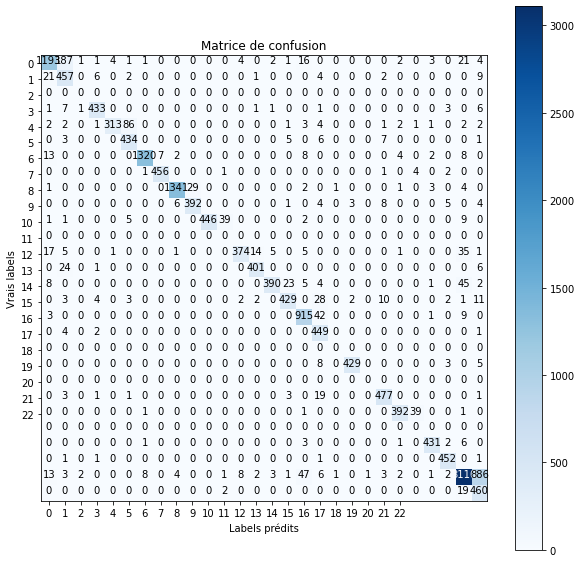

In [ ]:
# Matrice de Confusion

cnf_matrix = metrics.confusion_matrix(df_reel,df_pred)

classes = range(0,23)
plt.figure(figsize=(10, 10))


plt.imshow(cnf_matrix, interpolation='nearest',cmap='Blues')
plt.title("Matrice de confusion")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
    plt.text(j, i, cnf_matrix[i, j],
             horizontalalignment="center",
             color="white" if cnf_matrix[i, j] > ( cnf_matrix.max() / 2) else "black")

# plt.yticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13],['Apple', 'Blueberry', 'Cherry','Corn', 'Grape','Orange', 
#                                               'Peach','Pepper', 'Potato','Raspberry', 'Soybean','Squash','Strawberry','Tomato'])
plt.ylabel('Vrais labels')
# plt.xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13],['Apple', 'Blueberry', 'Cherry','Corn', 'Grape','Orange', 'Peach','Pepper', 
#                                               'Potato','Raspberry', 'Soybean','Squash','Strawberry','Tomato'],
                  # rotation = 90)

plt.xlabel('Labels prédits')

plt.show()

In [ ]:
print(metrics.classification_report(df_reel,df_pred))

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

     Apple_0       0.94      0.83      0.88      1441
     Apple_1       0.65      0.91      0.76       502
 Blueberry_0       0.00      0.00      0.00         0
 Blueberry_1       0.96      0.95      0.96       454
    Cherry_0       0.98      0.74      0.85       421
    Cherry_1       0.82      0.95      0.88       456
      Corn_0       0.99      0.97      0.98      1364
      Corn_1       0.98      0.98      0.98       465
     Grape_0       0.99      0.97      0.98      1382
     Grape_1       0.93      0.93      0.93       423
    Orange_0       1.00      0.89      0.94       503
    Orange_1       0.00      0.00      0.00         0
     Peach_0       0.96      0.81      0.88       459
     Peach_1       0.95      0.93      0.94       432
    Pepper_0       0.97      0.82      0.89       478
    Pepper_1       0.92      0.86      0.89       497
    Potato_0       0.91      0.94      0.93       970
    Potato_1       0.78    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
